1 – Imports + load the correct files

In [1]:
import spacy
from collections import Counter
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# --------- Load the text files from ../data ---------
DATA_DIR = Path("../data")

def find_file_by_keywords(dir_path, keywords):
    """
    Find the first file in dir_path whose name contains ALL keywords.
    Works with names like 'War-and-Peace.txt' or long Gutenberg names.
    """
    for path in dir_path.iterdir():
        if path.is_file():
            name_lower = path.name.lower()
            if all(k.lower() in name_lower for k in keywords):
                return path
    raise FileNotFoundError(f"No file found in {dir_path} with keywords {keywords}")

war_and_peace_path = find_file_by_keywords(DATA_DIR, ["war", "peace"])
anna_karenina_path = find_file_by_keywords(DATA_DIR, ["anna", "karenina"])

print("Using files:")
print("War and Peace  ->", war_and_peace_path.name)
print("Anna Karenina  ->", anna_karenina_path.name)

with war_and_peace_path.open(encoding="utf-8") as f:
    war_and_peace_text = f.read()

with anna_karenina_path.open(encoding="utf-8") as f:
    anna_karenina_text = f.read()

# Use only first N characters to keep things fast
N = 200_000   # you can increase later if you want
war_and_peace_text_sample = war_and_peace_text[:N]
anna_karenina_text_sample = anna_karenina_text[:N]

len(war_and_peace_text_sample), len(anna_karenina_text_sample)


Using files:
War and Peace  -> War-and-Peace.txt
Anna Karenina  -> Anna-Karenina.txt


(200000, 200000)

2 – spaCy setup + sampling

In [2]:
nlp = spacy.load("en_core_web_sm")


3 – Name normalization + extract_character_mentions

In [3]:
# --------- Map name variants to canonical names ---------
NAME_NORMALIZATION = {
    # --- War and Peace ---
    "Pierre": "Pierre Bezukhov",
    "Bezukhov": "Pierre Bezukhov",

    "Prince Andrei": "Andrei Bolkonsky",
    "Andrew": "Andrei Bolkonsky",
    "Prince Andrew": "Andrei Bolkonsky",
    "Andrei": "Andrei Bolkonsky",
    "Bolkonsky": "Andrei Bolkonsky",

    "Natasha": "Natasha Rostova",
    "Natalie": "Natasha Rostova",
    "Rostova": "Natasha Rostova",

    # --- Anna Karenina ---
    "Anna": "Anna Karenina",
    "Karenina": "Anna Karenina",

    "Vronsky": "Alexei Vronsky",

    "Levin": "Konstantin Levin",
    "Konstantin": "Konstantin Levin",

    "Kitty": "Ekaterina Shcherbatskaya",
    "Ekaterina Shcherbatskaya": "Ekaterina Shcherbatskaya",

    "Oblonsky": "Stepan Arkadyevitch Oblonsky",
    "Stepan Arkadyitch": "Stepan Arkadyevitch Oblonsky",
    "Stepan Arkadyevitch": "Stepan Arkadyevitch Oblonsky",
}


def normalize_name(name: str) -> str:
    return NAME_NORMALIZATION.get(name, name)

# --------- Extract character mentions per sentence ---------
def extract_character_mentions(text, book_label):
    doc = nlp(text)
    results = []

    for sent in doc.sents:
        persons = [ent.text for ent in sent.ents if ent.label_ == "PERSON"]
        if not persons:
            continue

        normalized = sorted(set(normalize_name(p) for p in persons))
        if len(normalized) < 2:
            continue

        results.append({
            "book": book_label,
            "sentence": sent.text.strip(),
            "characters": normalized,
        })

    return results

war_sent_data = extract_character_mentions(war_and_peace_text_sample, "War and Peace")
anna_sent_data = extract_character_mentions(anna_karenina_text_sample, "Anna Karenina")

len(war_sent_data), len(anna_sent_data)


(112, 78)

4 – Build co-occurrence 

In [4]:
def build_cooccurrence_edges(sent_data):
    edges = Counter()
    for item in sent_data:
        chars = item["characters"]
        for c1, c2 in itertools.combinations(chars, 2):
            pair = tuple(sorted((c1, c2)))
            edges[pair] += 1
    return edges

war_edges = build_cooccurrence_edges(war_sent_data)
anna_edges = build_cooccurrence_edges(anna_sent_data)

len(war_edges), len(anna_edges)


(133, 61)

5 – Create graphs

In [5]:
def edges_to_graph(edge_weights, min_weight=3):
    G = nx.Graph()
    for (c1, c2), w in edge_weights.items():
        if w >= min_weight:
            G.add_edge(c1, c2, weight=w)
    return G

G_war = edges_to_graph(war_edges, min_weight=3)
G_anna = edges_to_graph(anna_edges, min_weight=3)

G_war.number_of_nodes(), G_war.number_of_edges(), G_anna.number_of_nodes(), G_anna.number_of_edges()


(10, 8, 5, 4)

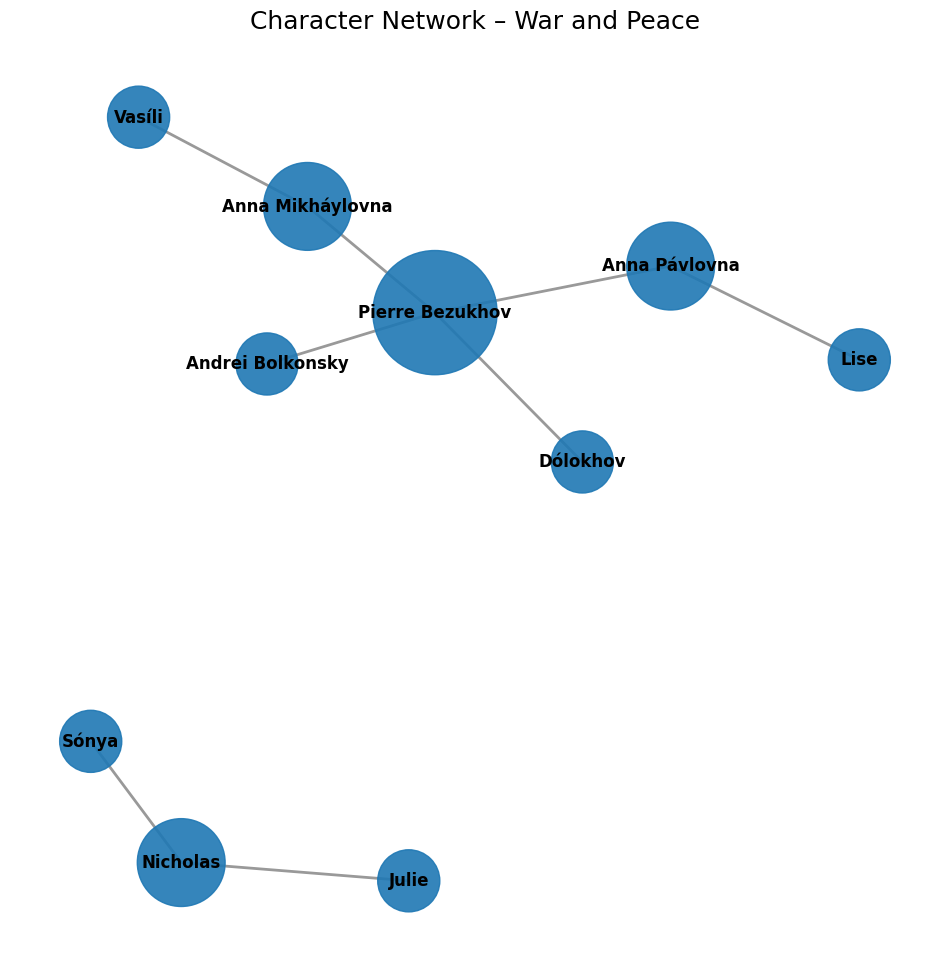

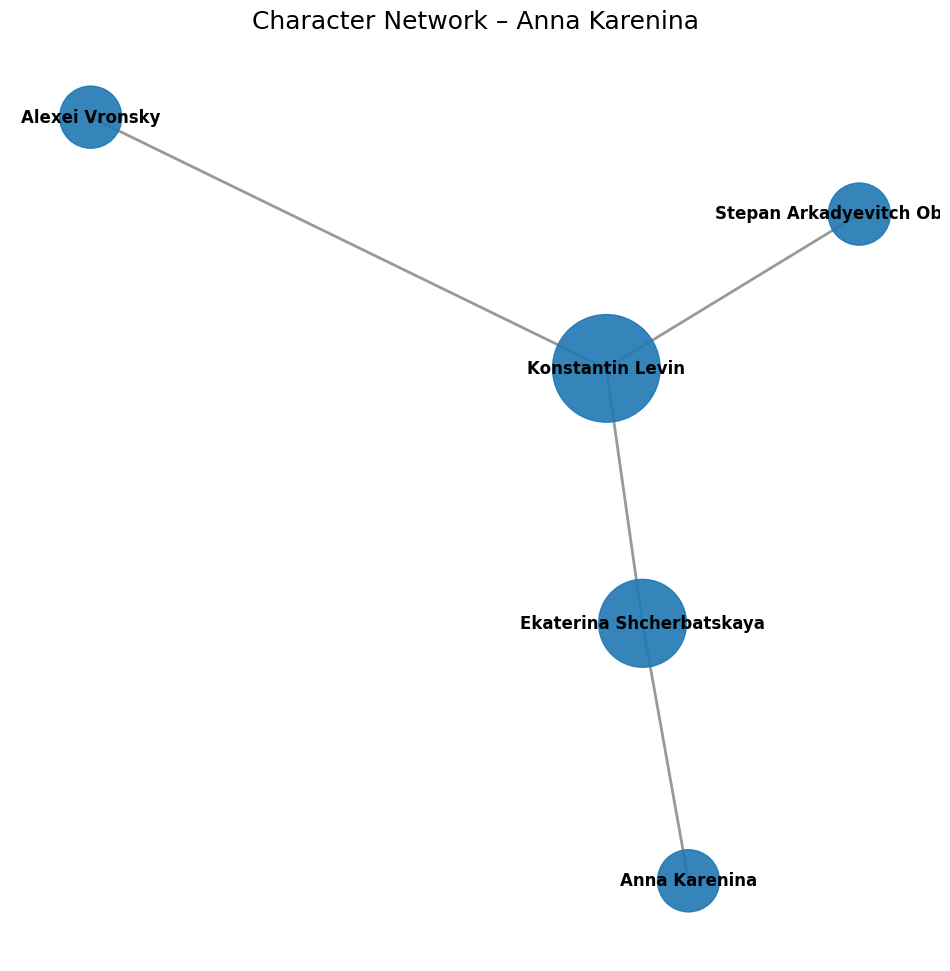

In [6]:
import matplotlib.pyplot as plt

def draw_character_network(G, title):
    plt.figure(figsize=(12, 12))  # BIGGER PLOT
    
    # positions of nodes (seed for repeatability)
    pos = nx.spring_layout(G, k=1.2, seed=42)  

    # node sizes = scaled degree
    degrees = dict(G.degree())
    node_sizes = [degrees[n] * 2000 for n in G.nodes()]  # much bigger so they are visible

    # draw
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.4)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")

    plt.title(title, fontsize=18)
    plt.axis("off")
    plt.show()

# show both
draw_character_network(G_war,  "Character Network – War and Peace")
draw_character_network(G_anna, "Character Network – Anna Karenina")


In [7]:
plt.savefig("../results/war_network.png", dpi=300, bbox_inches="tight")
plt.savefig("../results/anna_network.png", dpi=300, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>